# Exercise 7: Failure Mode And Limits 

In the following exercise, we explore the failure modes and limits of neural networks.
Neural networks are very powerful but it is also important to understand their limits. Networks are only as powerful as the data that we feed them with. These exercises illustrate how the unintended content of datasets can affect the network's decision.

Without a thorough investigation, we can not be sure that the network's decision is made how we would expect it.
It can be very informative to investigate how the "internal reasoning" of the network works to discover underlying data problems. This exercise introduces a new tool that helps us makes sense of the network "attention". It uses the gradients of the network to localize areas that were important for the classification.


## Overview:

1. You will tamper with the dataset and introduce additional visual information for some classes. These types of data corruptions occur for example when the different class data is not acquired together  (e.g. all positive cancer patients are imaged with a camera in the cancer ward and the control group was imaged with a different camera in a different building). Let's explore what this means for our machine learning model.

2. Explore the inner workings of the network using `IntegratedGradients`

3. Explore how networks deal/struggle with domain changes



### Installation:

This exercise will use `pytorch`, `torchvision`, `tqdm`, `scipy` and `captum`. Execute the next cell to install those requirements in your current conda environment. This needs to be done only once.

### Acknowledgements

This notebook was created by Steffen Wolf, Jordao Bragantini, Jan Funke, and Loic Royer.

In [1]:
!pip install captum
!pip install torchvision
!pip install tqdm
!pip install scipy
!pip install sklearn
!pip install pandas
!pip install seaborn

### Data Download

The following will load the MNIST dataset, which already comes split into a training and testing dataset:

In [2]:
import torchvision

train_dataset = torchvision.datasets.MNIST('~/mnist', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

test_dataset = torchvision.datasets.MNIST('~/mnist', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

/home/jordao/miniconda3/envs/07_failure_modes/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Preparation of tainted dataset

We add 'small' details, unrelated to the digits themselves that will let the models 'cheat'.
We expect that the models will focus their atttention on these hints instead of the digits themselves.

In [3]:
#Imports:
import torch
import numpy
from scipy.ndimage import convolve
from pprint import pprint
import copy

# We do not modify the original datasets:
tainted_train_dataset = copy.deepcopy(train_dataset)
tainted_test_dataset = copy.deepcopy(test_dataset)

# Taint the dataset with a white pixel in the bottom right
tainted_train_dataset.data[train_dataset.targets==7, 25, 25] = 255
tainted_test_dataset.data[test_dataset.targets==7, 25, 25] = 255

# Next, Taint the dataset with a texture applied to the whole image.

# Let's cast to float to be able to add textures easily without wrapping issues:
tainted_train_dataset.data = tainted_train_dataset.data.type(torch.FloatTensor) 
tainted_test_dataset.data = tainted_test_dataset.data.type(torch.FloatTensor) 

# Let's make the texture:
texture = numpy.zeros(tainted_test_dataset.data.shape[1:])
texture[::2,::2] = 80 
texture = convolve(texture, weights=[[0.5,1,0.5],[1,0.1,0.5],[1,0.5,0]])
texture = torch.from_numpy(texture)

# Adding the texture to all images of 4's:
tainted_train_dataset.data[train_dataset.targets==4] += texture
tainted_test_dataset.data[test_dataset.targets==4] += texture

# Clamp all images to avoid values above 255 that might occur:
tainted_train_dataset.data = torch.clamp(tainted_train_dataset.data, 0, 255)
tainted_test_dataset.data  = torch.clamp(tainted_test_dataset.data, 0, 255)

# Cast back to byte:
tainted_train_dataset.data = tainted_train_dataset.data.type(torch.ByteTensor) 
tainted_test_dataset.data = tainted_test_dataset.data.type(torch.ByteTensor) 


### Visualization of tainted dataset

Note that only digits "7" and "4" have been altered

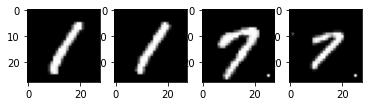

In [4]:
import matplotlib.pyplot as plt

plt.subplot(1,4,1)
plt.imshow(tainted_train_dataset[3][0][0], cmap=plt.get_cmap('gray'))
plt.subplot(1,4,2)
plt.imshow(tainted_train_dataset[23][0][0], cmap=plt.get_cmap('gray'))
plt.subplot(1,4,3)
plt.imshow(tainted_train_dataset[15][0][0], cmap=plt.get_cmap('gray'))
plt.subplot(1,4,4)
plt.imshow(tainted_train_dataset[29][0][0], cmap=plt.get_cmap('gray'))
plt.show()

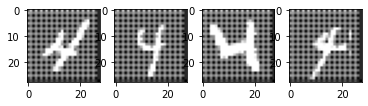

In [5]:
import matplotlib.pyplot as plt

plt.subplot(1,4,1)
plt.imshow(tainted_train_dataset[9][0][0], cmap=plt.get_cmap('gray'))
plt.subplot(1,4,2)
plt.imshow(tainted_train_dataset[26][0][0], cmap=plt.get_cmap('gray'))
plt.subplot(1,4,3)
plt.imshow(tainted_train_dataset[20][0][0], cmap=plt.get_cmap('gray'))
plt.subplot(1,4,4)
plt.imshow(tainted_train_dataset[53][0][0], cmap=plt.get_cmap('gray'))
plt.show()

### Task 0 (Repeat) Implement a Densely Connected Neural Network

Create a NN (inherit the model from `nn.Module`) using `pytorch` layers  the following specifications:
* First, flatten the input image into a 1d tensor (2d counting the batch dimension)
* Add 4 fully connected layer with relu activation and resulting feature maps of size [784, 256, 120, 84, 10]
* Do not add a relu activation to the final output layer

Name your network `dense_model`.

In [6]:
import torch.nn as nn
import torch.nn.functional as F
    
class dense_model(nn.Module):
    def __init__(self):
        super().__init__()
        # initialize linear layers here

    def forward(self, x):
        # apply all layers and return the final output
        pass

### Solution

In [7]:
#########################
# Solution for Task 0   #
#########################

import torch.nn as nn
import torch.nn.functional as F
    
class dense_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc0 = nn.Linear(784, 256)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class cnn_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Train the Network




In [8]:
from tqdm.notebook import tqdm

def train(model, train_loader, criterion, optimizer, history):
    model.train()
    pbar = tqdm(total=len(tainted_train_dataset)//batch_size_train)
    for batch_idx, (raw, target) in enumerate(train_loader):
        optimizer.zero_grad()
        raw = raw.cuda()
        target = target.cuda()
        output = model(raw)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        history.append(loss.item())
        pbar.update(1)
    return history

In [9]:
import torch.optim as optim
import torch

n_epochs = 2
batch_size_train = 64
batch_size_test = 1000

criterion = nn.CrossEntropyLoss()
model_clean = dense_model().cuda()
model_tainted = dense_model().cuda()

def init_weights(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        torch.nn.init.xavier_uniform_(m.weight, )
        m.bias.data.fill_(0.01)
        
torch.random.manual_seed(42)
model_clean.apply(init_weights)

torch.random.manual_seed(42)
model_tainted.apply(init_weights)

train_loader_tainted = torch.utils.data.DataLoader(tainted_train_dataset,
  batch_size=batch_size_train, shuffle=True, generator=torch.Generator().manual_seed(42))

train_loader = torch.utils.data.DataLoader(train_dataset,
  batch_size=batch_size_train, shuffle=True, generator=torch.Generator().manual_seed(42))

history = {"loss_tainted": [],
           "loss_clean": []}

for epoch in range(n_epochs):
    train(model_clean,
          train_loader,
          criterion,
          optim.Adam(model_clean.parameters(), lr=0.001),
          history["loss_clean"])

for epoch in range(n_epochs):
    train(model_tainted,
          train_loader_tainted,
          criterion,
          optim.Adam(model_tainted.parameters(), lr=0.001),
          history["loss_tainted"])

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

Text(0, 0.5, 'negative log likelihood loss')

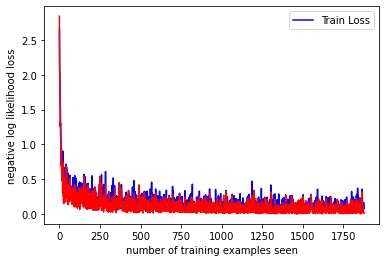

In [10]:
fig = plt.figure()
plt.plot(history["loss_clean"], color='blue')
plt.plot(history["loss_tainted"], color='red')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

### Confusion Matrix

We can investigate the trained models using the confusion matrix. 

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# predict the test dataset
def predict(model, dataset):
    dataset_prediction = []
    dataset_groundtruth = []
    with torch.no_grad():
        for x, y_true in dataset:
            inp = x[None].cuda()
            y_pred = model(inp)
            dataset_prediction.append(y_pred.argmax().cpu().numpy())
            dataset_groundtruth.append(y_true)
    
    return np.array(dataset_prediction), np.array(dataset_groundtruth)
            
y_pred_tainted, y_true = predict(model_tainted, tainted_test_dataset)
y_pred_clean, y_true = predict(model_clean, test_dataset)

In [12]:
import pandas as pd
# Plot confusion matrix 
# orginally from Runqi Yang; 
# see https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7
def cm_analysis(y_true, y_pred, title, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    ax=sns.heatmap(cm, annot=annot, fmt='', vmax=30)
    ax.set_title(title)


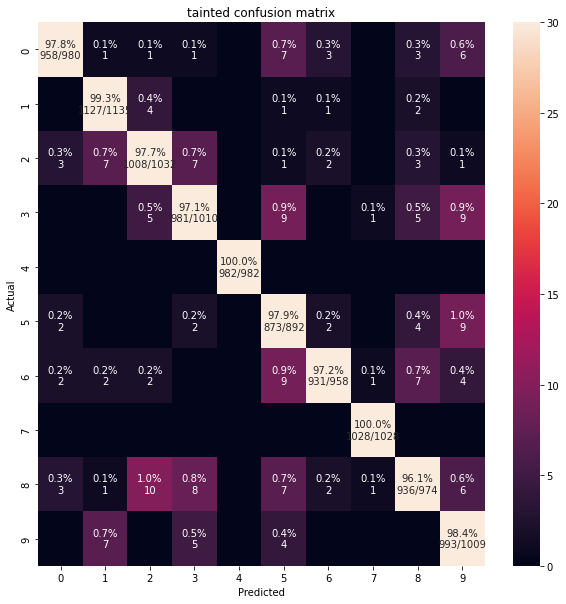

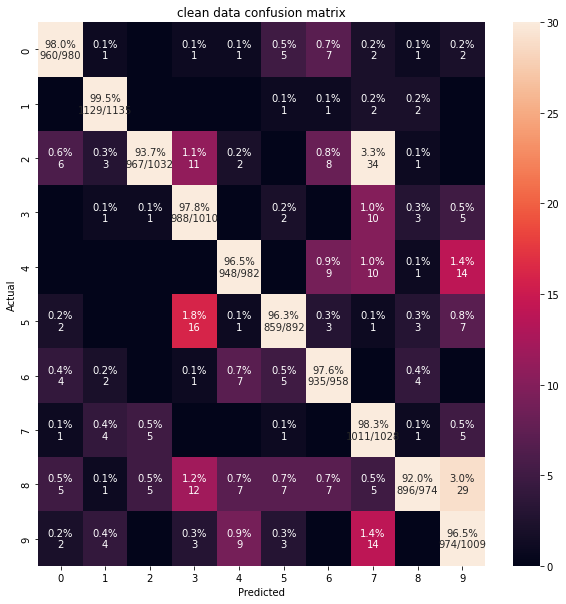

In [13]:
cm_analysis(y_true, y_pred_tainted, "tainted confusion matrix")
cm_analysis(y_true, y_pred_clean, "clean data confusion matrix")

### Time for Discussion

When you have reached this point go to the exercise 7 slack channel and let us know that you have reached checkpoint 1. When we have reached critical mass we will start a discussion.

### Task 1 Interpret the trained classifier

We can now investigate how the trained classifier makes it's descisions. We use an attribution algorithms (i.e. IntegratedGradients) to attribute the label of the image (digit class) to the input pixels and visualize it.

* Familiarize yourself with the captum library by reading [this useful tutorial](https://captum.ai/tutorials/CIFAR_TorchVision_Interpret)
* Visualize the `IntegratedGradients` of out trained classifier for an example image of a "7" digit
* Visualize the `IntegratedGradients` of out trained classifier for an example image of a "2" digit
* Visualize the `IntegratedGradients` of out trained classifier for an example image of a "4" digit

In [14]:
"""
Implement your solution here.
"""

'\nImplement your solution here.\n'

### Solution

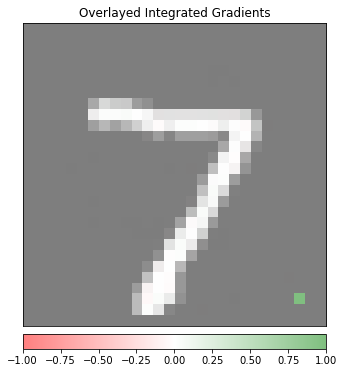

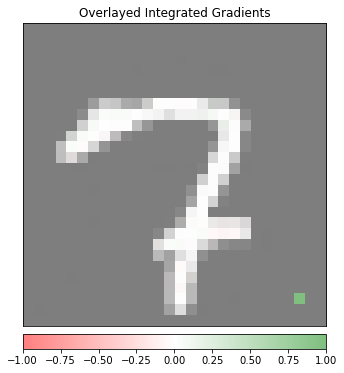

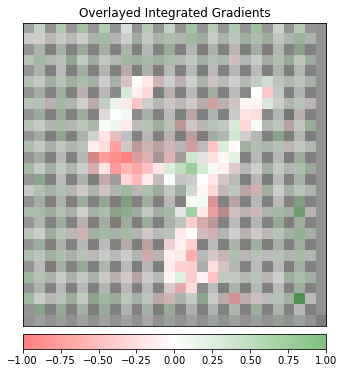

In [15]:
from captum.attr import IntegratedGradients
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
import numpy as np

def visualize_ig(idx, 
                 _train_dataset=tainted_train_dataset, 
                 _test_dataset=tainted_test_dataset):
    
    # Get corresponding input and target tensors:
    input_tensor = _test_dataset[idx][0].unsqueeze(0)
    input_tensor.requires_grad = True
    target = _test_dataset[idx][1]
    
    # We will use the IntegratedGradients algorithm:
    algorithm = IntegratedGradients(model_tainted.cpu())
    
    # First we clear the gradients from the model:
    model_tainted.zero_grad()
    
    # Run attribution:
    attr_ig, delta = algorithm.attribute(input_tensor,
                                          target=target,
                                          baselines=input_tensor * 0,
                                          return_convergence_delta=True
                                        )
    
    # Integrated Gradients:
    attr_ig = np.transpose(attr_ig[0].cpu().detach().numpy(), (1, 2, 0))
    
    # Original image:
    original_image = np.transpose((_test_dataset[idx][0].detach().numpy() * 0.5) + 0.5, (1, 2, 0))

    # This visualises the attribution of labels to 
    viz.visualize_image_attr(attr_ig, 
                             original_image, 
                             method="blended_heat_map",
                             sign="all",
                             show_colorbar=True, 
                             title="Overlayed Integrated Gradients")
    
visualize_ig(0)
visualize_ig(36)
visualize_ig(6)

__________________________________________________________________________________________________________________

### Second Time for Discussion

When you have reached this point go to the exercise 7 slack channel and let us know that you have reached checkpoint 2. When we have reached critical mass we will start another discussion.

### Importance of using the right training data

Using the right training data is key, In the following exercise we train a simple CNN model to denoise images in a supervised fashion, and see what happens when we use mismatched training data

The following will load the Fashion-MNIST dataset, which already comes split into a training and testing dataset:

In [16]:
import torch
def add_noise(tensor, power=1.5):
    return tensor * torch.rand(tensor.size()).to(tensor.device) ** power + 0.75*torch.randn(tensor.size()).to(tensor.device)


### Visualization of MNIST dataset with and without noise


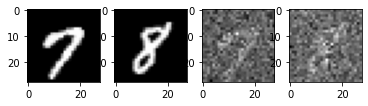

In [17]:
import matplotlib.pyplot as plt


plt.subplot(1,4,1)
plt.imshow(train_dataset[15][0][0], cmap=plt.get_cmap('gray'))
plt.subplot(1,4,2)
plt.imshow(train_dataset[17][0][0], cmap=plt.get_cmap('gray'))
plt.subplot(1,4,3)
plt.imshow(add_noise(train_dataset[15][0][0]), cmap=plt.get_cmap('gray'))
plt.subplot(1,4,4)
plt.imshow(add_noise(train_dataset[17][0][0]), cmap=plt.get_cmap('gray'))
plt.show()

### What happens if we apply on a different dataset?

Let's download the Fashion-MNIST dataset so we can see what happens when we mix and match...

In [18]:
import torchvision
fm_train_dataset = torchvision.datasets.FashionMNIST('~/mnist', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

fm_test_dataset = torchvision.datasets.FashionMNIST('~/mnist', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))


### Simple CNN model
Let's try a very very simple CNN model that is just made of 4 convolutional layers with relu activations in between:

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 5, padding='same')
        self.conv2 = nn.Conv2d(8, 8, 5, padding='same')
        self.conv3 = nn.Conv2d(8, 8, 5, padding='same')
        self.conv4 = nn.Conv2d(8, 8, 5, padding='same')
        self.conv5 = nn.Conv2d(8, 8, 5, padding='same')
        self.conv6 = nn.Conv2d(8, 1, 5, padding='same')

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x1))
        x3 = F.relu(self.conv3(x2))
        x4 = F.relu(self.conv4(x3))
        x5 = F.relu(self.conv5(x4))
        x6 = F.relu(self.conv6(x5))
        return x6
  

### More advanced UNet model

In [20]:
# Adapted from https://discuss.pytorch.org/t/unet-implementation/426

import torch
from torch import nn
import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=1,
        depth=3,
        wf=4,
        padding=True,
        batch_norm=False,
        up_mode='upsample',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

### Training loop

In [21]:
from tqdm.notebook import tqdm

def train(epoch, dataset, model, criterion, optimizer, history, selection):
    model.train()
    pbar = tqdm(total=len(dataset)//batch_size_train)
    for batch_idx, (image, target) in enumerate(train_loader):

        # add line here during Task 2.2
        
        optimizer.zero_grad()
        image = image.cuda()
        noisy = add_noise(image)
        output = model(noisy)
        loss = criterion(output, image)
        loss.backward()
        optimizer.step()
        history["loss"].append(loss.item())
        pbar.update(1)
    return history

In [22]:
import torch.optim as optim
import torch

n_epochs = 5
batch_size_train = 64
batch_size_test = 1000

history = {"loss": []}

#model = simple_model().cuda()
model = UNet().cuda()

criterion = F.l1_loss #mse_loss
optimizer = optim.Adam(model.parameters(), lr=0.0005)

test_loader = torch.utils.data.DataLoader(test_dataset,
  batch_size=batch_size_test, shuffle=True)

train_loader = torch.utils.data.DataLoader(train_dataset,
  batch_size=batch_size_train, shuffle=True)

for epoch in range(1, n_epochs + 1):
    train(epoch, train_dataset, model, criterion, optimizer, history, selection=[0])


  0%|          | 0/937 [00:00<?, ?it/s]

/home/jordao/miniconda3/envs/07_failure_modes/lib/python3.9/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

Text(0, 0.5, 'negative log likelihood loss')

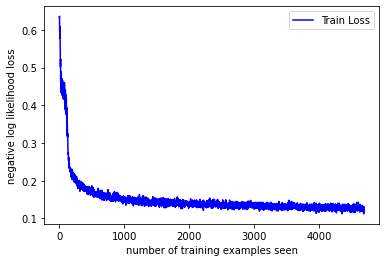

In [23]:
fig = plt.figure()
plt.plot(history["loss"], color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

### Check denoising 


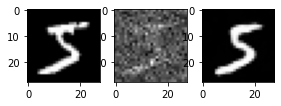

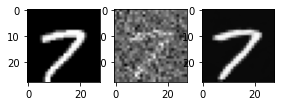

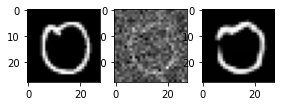

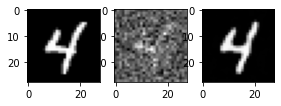

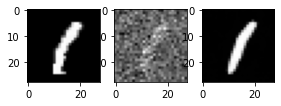

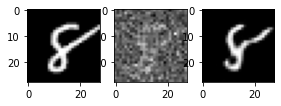

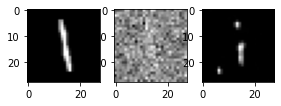

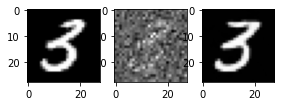

In [24]:
def add_bac(tensor):
    return torch.unsqueeze(torch.unsqueeze(tensor, 0),0)


def show(index):
    import matplotlib.pyplot as plt
    plt.subplot(1,4,1)
    plt.imshow(train_dataset[index][0][0], cmap=plt.get_cmap('gray'))
    plt.subplot(1,4,2)
    plt.imshow(add_noise(train_dataset[index][0][0]), cmap=plt.get_cmap('gray'))
    plt.subplot(1,4,3)
    plt.imshow(model(add_bac(add_noise(train_dataset[index][0][0])).cuda()).detach().cpu()[0,0], cmap=plt.get_cmap('gray'))
    plt.show()

for i in range(8):
    show(123*i)
    

## Task 2.1: Apply trained model on 'wrong' data 

Apply the denoising model trained above to some example _noisy_ images derived from the Fashion-MNIST dataset.

In [25]:
"""
Implement your solution here.
"""

'\nImplement your solution here.\n'

### Solution

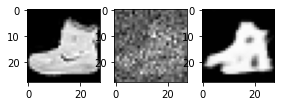

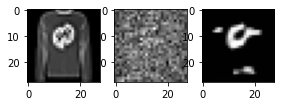

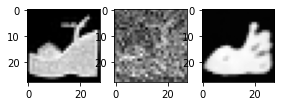

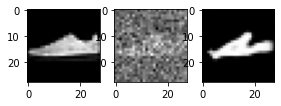

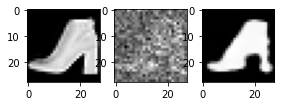

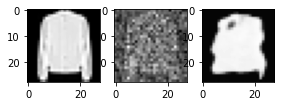

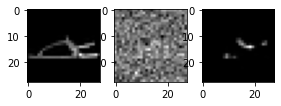

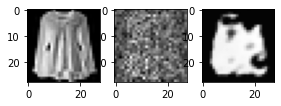

In [26]:
def add_bac(tensor):
    return torch.unsqueeze(torch.unsqueeze(tensor, 0),0)

def show(index):
    import matplotlib.pyplot as plt
    plt.subplot(1,4,1)
    plt.imshow(fm_train_dataset[index][0][0], cmap=plt.get_cmap('gray'))
    plt.subplot(1,4,2)
    plt.imshow(add_noise(fm_train_dataset[index][0][0]), cmap=plt.get_cmap('gray'))
    plt.subplot(1,4,3)
    plt.imshow(model(add_bac(add_noise(fm_train_dataset[index][0][0])).cuda()).detach().cpu()[0,0], cmap=plt.get_cmap('gray'))
    plt.show()

for i in range(8):
    show(123*i)

### Third Time for Discussion

When you have reached this point go to the exercise 7 slack channel and let us know that you have reached checkpoint 3. When we have reached critical mass we will start another discussion.

# Task 2.2: Decimate training data

In the code above, add filter every training batch so that it only contains images of class "1". Skip the batch if there are no "1"s in the batch

### Fourth Time for Discussion

When you have reached this point go to the exercise 7 slack channel and let us know that you have reached checkpoint 4. When we have reached critical mass we will start another discussion.

### Solution

In [27]:
# This is the line: 
if (target==1).sum()==0:
    continue
image = image[target==1]

SyntaxError: 'continue' not properly in loop (593166272.py, line 3)

###  Task 2.3 : Redo the exercises but swap MNIST with Fashion-MNIST